In [1]:
import os
import numpy as np
from spectral import *
import matplotlib.pyplot as plt
import math
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn import preprocessing
import pickle

DATASTORE = 'C:\\Datasets\\bacterias'
spectral.settings.envi_support_nonlowercase_params = True


In [57]:
from sklearn.cluster import KMeans
from math import factorial
import random

def get_fewer_lines(mat, ammount):
    n_mat = []
    r, _, _ = mat.shape
    for i in range(int(r/ammount)):
        n_mat.append(mat[ammount * i, :, :])
    return np.array(np.squeeze(n_mat, axis=1))

def calibration(I, W, D):
    row,column,wave = I.shape
    arr = np.copy(I)

    for w in range(wave):
        if (w % 30 == 0):
            print('CAMADAS {}-{}'.format(w, 256 if w+30>256 else w+30))

        WW = np.mean(W[:, :, w], axis=0).T
        DD = np.mean(D[:, :, w], axis=0).T
        for i in range(row):
            for j in range(column):
                den = WW[j] - DD[j]
                num = I[i, j, w] - DD[j]
                if den and num/den > 0:
                    arr[i, j, w] = -math.log10(num / den)
                else:
                    arr[i, j, w] = 0
    return arr

def hsi2matrix(arr):
    if len(arr.shape) != 3:
        raise BaseException('A entrada deve possuir 3 dimensões')

    r, c, w = arr.shape
    return np.reshape(arr, (r*c, w))

def mat2hsi(mat, shape):
    return np.reshape(mat, shape)

def pca_95(x):
    scaled_data = preprocessing.scale(x)
    return PCA(n_components=0.95).fit_transform(scaled_data)

def get_clusters(x):
    pca_data = pca_95(x)
    km = KMeans(n_clusters=2).fit(pca_data)
    return km

def get_layer(hsi, layer):
    return hsi[:,:,layer]


def savitzky_golay_filter(y, window_size, order, deriv=0, rate=1):
    order_range = range(order+1)
    half_window = (window_size - 1) // 2
    b = np.mat([[k**i for i in order_range]
               for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    firstvals = y[0] - np.abs(y[1:half_window+1][::-1] - y[0])
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve(m[::-1], y, mode='valid')

def snv_filter(mat):
    nmat = np.copy(mat)
    mean = np.mean(mat, axis=1)
    std = np.std(mat, axis=1)
    for i in range(mat.shape[0]):
        nmat[i] = (nmat[i] - mean[i])/std[i]

    return nmat

def remove_pixels(mat, side, amount):
    cpy_mat = np.copy(mat)
    if side == 'top':
        for i in range(amount):
            cpy_mat[i, :, :] = 0
    return cpy_mat

def apply_mask(km,mat):
    mask1 = np.copy(mat)
    mask2 = np.copy(mat)
    lab = km.labels_
    for i in range(mat.shape[0]):
        if lab[i] == 0:
            mask1[i] = 0
        else:
            mask2[i] = 0
    
    return (mat2hsi(mask1, mat.shape) ,mat2hsi(mask2, mat.shape))


def hsi_remove_background(mat):
    # mat_cpy = np.copy(mat)
    mat_cpy = apply_filters(mat)
    km = get_clusters(mat_cpy)
    m1, m2 = apply_mask(km, mat)
    return (m1,m2,km)
    
def which_cluster_to_mantain(mask1, mask2):
    plt.figure()
    plt.title("FIGURE 1")
    plt.imshow(get_layer(mask1, 1), cmap='gray')
    plt.figure()
    plt.title("FIGURE 2")
    plt.imshow(get_layer(mask2, 2), cmap='gray')
    plt.show()
    
    resp = int(input('Qual cluster deseja manter? (1/2)'))
    if resp != 1 and resp != 2:
        raise BaseException("Selected option not available.")
    
    return resp - 1
    
def get_hsi_data(path):
    orig_name = [a for a in os.listdir(path) if '.hdr' in a and 'DARK' not in a and 'WHITE' not in a]
    dark_name = [a for a in os.listdir(path) if '.hdr' in a and 'DARK' in a]
    white_name = [a for a in os.listdir(path) if '.hdr' in a and 'WHITE' in a]

    I = open_image(os.path.join(path, orig_name[0]))
    W = open_image(os.path.join(path, white_name[0]))
    D = open_image(os.path.join(path, dark_name[0]))

    return (I.load(), W.load(), D.load())

def get_no_background_pixels(cluster: int, km, mat):
    lab = km.labels_
    arr = []
    for i in range(mat.shape[0]):
        if lab[i] == cluster:
            arr.append(mat[i,:])
    return arr

def apply_filters(mat):
    mat_cpy = np.copy(mat)
    for i in range(mat.shape[0]):
        mat_cpy[i] = savitzky_golay_filter(mat_cpy[i], 21, 2, 1)

    return snv_filter(mat_cpy)

def create_training_data_full(choose_bac: int):
    """
        choose_bac is the bacteria to process (since takes forever to do all at once)
        returns a calibrated array based on dark and white hdr's, the pixels containing the bacteria (with no background) and the label for that bacteria
    """

    bac_dirs = os.listdir(DATASTORE)

    for ind, bac in enumerate(bac_dirs):
        if (choose_bac == ind):

            individual_bac_dir = os.path.join(DATASTORE, bac)

            I, W, D = get_hsi_data(individual_bac_dir)

            W = get_fewer_lines(W, 25)
            D = get_fewer_lines(D, 25)

            arr_calib = calibration(I, W, D)

            cube, noBackPixels = create_training_data_from_calibration(arr_calib)
            return [arr_calib, cube, noBackPixels, choose_bac]
            
def create_training_data_from_calibration(arr_calib):
    cube = replace_median(arr_calib)

    mat = hsi2matrix(cube)

    mask1, mask2, km = hsi_remove_background(mat)
    mask1 = mat2hsi(mask1, arr_calib.shape)
    mask2 = mat2hsi(mask2, arr_calib.shape)
    mat = apply_filters(mat)

    cluster = which_cluster_to_mantain(mask1, mask2)
    noBackPixels = get_no_background_pixels(cluster, km, mat)
    if cluster == 0:
        return mat2hsi(mask1, arr_calib.shape), noBackPixels
    return mat2hsi(mask1, arr_calib.shape), noBackPixels

def replace_median(cube):
    x,y,z = cube.shape
    for i in range(z):
        rows, cols = np.where(cube[:,:,i] == 0)
        for j in range(len(rows)):
            if rows[j] > 1 and cols[j] > 1 and rows[j] < x - 1 and cols[j] < y - 1:
                wdn = cube[rows[j]-1:rows[j]+2, cols[j]-1: cols[j]+2, i]
                r, _ = np.where(wdn == 0)
                if len(r) == 1:
                    wdn = np.where(wdn != 0)
                    cube[rows[j], cols[j], i] = np.median(wdn)
    return cube

def save_calibrated(filename):
    pickle_out = open(filename, "wb")
    pickle.dump(calib_arr, pickle_out)
    pickle_out.close()

def load_calib(filename):
    pickle_in = open(filename, "rb")
    return pickle.load(pickle_in)

def plot_dif_with_ref_cube(mat):
    path = os.path.join(DATASTORE, 'teste')
    ref_img = np.array(loadmat(os.path.join(path, 'a.mat'))['data'])

    nn = hsi2matrix(mat)
    NN = hsi2matrix(ref_img)

    _nn = np.mean(nn, axis=0)
    _NN = np.mean(NN, axis=0)

    print(np.mean(nn) - np.mean(NN), math.sqrt(np.mean(np.square(nn - NN))))

    x = np.linspace(0, 241, 241)
    plt.plot(x, _nn, '-g', label='minha')
    plt.plot(x, _NN, ':b', label='ref')
    plt.legend()

def plot_imgs(img1, img2):
    plt.imshow(img1[:,:,0], cmap='gray')
    plt.figure()
    plt.imshow(img2[:,:,0], cmap='gray')
    plt.show()

def get_filename_on_index(path, index):
    return os.listdir(path)[index]

def plot_dif_pixel(img1, img2):
    r,c,w = img1.shape

    for k in range(w):
        for i in range(r):
            for j in range(c):
                if img1[i,j,k] != img2[i,j,k]:
                    print('Pixel {}.{}.{} IMG1: {} IMG2: {}'.format(
                        i, j, k, img1[i, j, k], img2[i, j, k]))


CAMADAS 0-30
CAMADAS 30-60
CAMADAS 60-90
CAMADAS 90-120
CAMADAS 120-150
CAMADAS 150-180
CAMADAS 180-210
CAMADAS 210-240
CAMADAS 240-256


C:\Users\Vinicius Moraes\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Vinicius Moraes\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


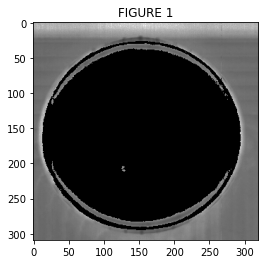

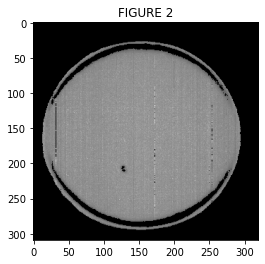

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [58]:
ind_to_process = 0

calib_arr, img_with_mask, only_pixels, ind = create_training_data_full(
    ind_to_process)
# path = os.path.join(DATASTORE, 'calibrated_pickles')
# save_calibrated(os.path.join(
#     path, get_filename_on_index(DATASTORE, ind_to_process)))


In [ ]:
mat, _ = create_training_data_from_calibration(calib_arr)

In [ ]:
path = os.path.join(DATASTORE, 'teste')
ref_img = np.array(loadmat(os.path.join(path, 'a.mat'))['data'])
plot_dif_with_ref_cube(mat, ref_img)


0.0 0.0
0.013552978020168638 0.24275456330185455


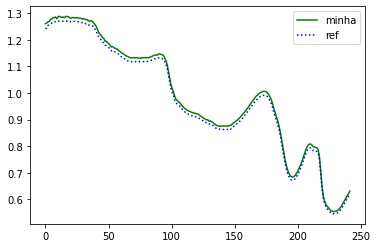

In [49]:
plot_dif_with_ref_cube(mat)

In [41]:
path = os.path.join(DATASTORE, 'teste')

orig_name = 'a.hdr'
dark_name = 'd.hdr'
white_name = 'w.hdr'

I = open_image(os.path.join(path, orig_name))
W = open_image(os.path.join(path, white_name))
D = open_image(os.path.join(path, dark_name))

arr = I.load()
W = W.load()
D = D.load()

WW = get_fewer_lines(D, 25)
print(WW.shape)

# mat = hsi2matrix(arr)
# m1, m2, km = hsi_remove_background(mat)
# mm1 = mat2hsi(m1, arr.shape)
# mm2 = mat2hsi(m2, arr.shape)

# sc = which_cluster_to_mantain(mm1, mm2)
# noBackPixels = get_no_background_pixels(0, km, mat)


(4, 320, 256)
